In [1]:
%cd /data/gunsbrother/repos/vq2d-lightning
%load_ext autoreload
%autoreload 2

/data/gunsbrother/repos/vq2d-lightning


/home/gunsbrother/.local/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from IPython.display import Image as IPImage

from ltvu.lit.model import LitModule
from ltvu.lit.data import LitVQ2DDataModule

import hydra
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf
from diffusers.utils import make_image_grid

import torch
import torchvision.transforms.functional as TF
from einops import rearrange, repeat
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO


def ten2pil(tensor, pad: float = 0.02, alpha = None, cmap = 'viridis'):
    assert tensor.dim() in (2, 3)  # (H, W), (C, H, W)
    tensor = tensor.cpu()
    tensor -= tensor.min()
    tensor /= tensor.max()

    if tensor.dim() == 3:
        tensor = tensor.permute(1, 2, 0)
        assert tensor.shape[-1] == 3

    fig = plt.figure(figsize=(5, 5))
    ax = plt.Axes(fig, [pad, pad, 1. - 2* pad, 1. - 2 * pad])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(tensor, aspect='equal', alpha=alpha, cmap=cmap)

    plots_io = BytesIO()
    fig.savefig(plots_io, format='jpg' if alpha is None else 'png', bbox_inches='tight', pad_inches=0)
    plt.close()

    img = Image.open(plots_io)
    # plots_io.close()
    return img

GlobalHydra.instance().clear()
OmegaConf.clear_resolvers()
OmegaConf.register_new_resolver("job_type", lambda : 'debug')
OmegaConf.register_new_resolver('runtime_outdir', lambda : 'outputs/tmp')
OmegaConf.register_new_resolver("eval", eval)
OmegaConf.register_new_resolver("tuple", lambda *args: tuple(args))
hydra.initialize(config_path='config', job_name='asdasdasdasdasd')

/tmp/ipykernel_3793772/2258718274.py:51: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path='config', job_name='asdasdasdasdasd')


hydra.initialize()

In [3]:
path_ckpt = 'outputs/batch/2024-09-15/123741/epoch=61-prob_acc=0.7739.ckpt'
plm_base = LitModule.load_from_checkpoint(path_ckpt).cuda()
plm_base.eval()
plm_base.freeze()

# path_ckpt = 'outputs/batch/2024-10-19/133186/epoch=54-prob_acc=0.7952.ckpt'
# path_ckpt = 'outputs/batch/2024-10-21/133643/epoch=22-prob_acc=0.7899.ckpt'
# path_ckpt = 'outputs/batch/2024-10-18/132949/epoch=43-prob_acc=0.7532.ckpt'  # loss 없는 거
# path_ckpt = 'outputs/batch/2024-11-01/136610/epoch=41-prob_acc=0.7555.ckpt'
# path_ckpt = 'outputs/batch/2024-11-01/136637/epoch=43-prob_acc=0.7646.ckpt'  # 1차 baseline
# path_ckpt = 'outputs/batch/2024-11-02/137072/epoch=20-prob_acc=0.7532.ckpt'
# path_ckpt = 'outputs/ckpts/34180/epoch=27-prob_acc=0.7698.ckpt'  # 1차 baseline + PCA guide
# path_ckpt = 'outputs/batch/2024-10-30/135920/epoch=20-prob_acc=0.7694.ckpt'  # 2차 baseline
# path_ckpt = 'outputs/batch/2024-11-03/137206/epoch=40-prob_acc=0.7928.ckpt'  # ours + loss
# path_ckpt = 'outputs/batch/2024-11-03/137211/epoch=40-prob_acc=0.7946.ckpt'  # ours + loss + border 무시
# path_ckpt = 'outputs/batch/2024-11-05/138123/epoch=60-iou=0.5432.ckpt'  # ours
path_ckpt = 'outputs/batch/2024-11-08/140333/epoch=12-prob_acc=0.7801.ckpt'
plm = LitModule.load_from_checkpoint(path_ckpt).cuda()
plm.eval()
plm.freeze()

eval_config = hydra.compose(config_name='eval', overrides=[
    f'ckpt={path_ckpt.replace('=', '\\=')}',
    f'batch_size=1',
    f'num_workers=4',
    f'prefetch_factor=1'
])
pdm = LitVQ2DDataModule(eval_config)  # won't use trainer here nor batched forward pass so no need to load the eval config and plm.config is enough
pdm.batch_size = 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].


dict_keys(['segment', 'query', 'gt_bboxes', 'gt_probs', 'before_query_mask', 'video_uid', 'clip_uid', 'annotation_uid', 'seg_idxs', 'query_set', 'clip_fps', 'query_frame', 'visual_crop', 'object_title'])
plant vase


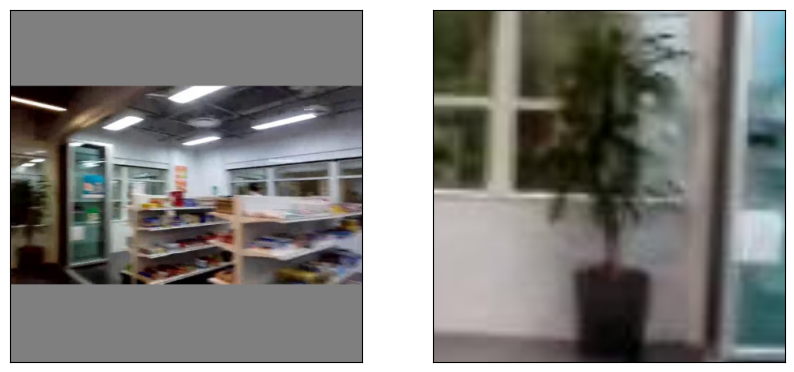

In [4]:
# get
# bidx = 2
# bidx = 300  # mean iou: 0 vs. 0.450
# bidx = 1307  # mean iou:
# bidx = 2300  # 슬리퍼
# bidx = 2305  # 물병
# bidx = 2333  # 상자
# bidx = 2334  # 화분
# bidx = 4001  # 주걱: 화면 전환 빠름
bidx = 4013  # 화분: 화면 전환 빠름
# bidx = 3900  # 예초기: baseline iou 0.197
# bidx = 3906  # 메탈프레임: baseline prob 0.56
# bidx = 3915

batch = pdm.get_val_sample(idx=bidx)
for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        batch[k] = v.cuda()

# viz
print(batch.keys())
print(batch['object_title'][0])
seg = rearrange(batch['segment'][0], 't c h w -> t h w c').cpu().numpy()
q = rearrange(batch['query'][0], 'c h w -> h w c').cpu().numpy()
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes[0]
ax.imshow(seg[len(seg) // 2])
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax = axes[1]
ax.imshow(q)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.show()

In [5]:
out1 = None
out2 = None
with torch.inference_mode():
    inputs = dict(**batch)
    inputs['segment'], inputs['query'] = pdm.normalize(inputs['segment'], inputs['query'])
    # inputs['query'] = inputs['query'].transpose(-1, -2)  # [B, C, H, W] -> [B, C, W, H]
    out1 = plm_base.model.forward(**inputs, compute_loss=True, get_intermediate_features=True, training=False)
    out2 = plm.model.forward(**inputs, compute_loss=True, get_intermediate_features=True, training=False)

W1108 15:45:55.641000 140673819596608 torch/_dynamo/variables/tensor.py:715] [1/0] Graph break from `Tensor.item()`, consider setting:
W1108 15:45:55.641000 140673819596608 torch/_dynamo/variables/tensor.py:715] [1/0]     torch._dynamo.config.capture_scalar_outputs = True
W1108 15:45:55.641000 140673819596608 torch/_dynamo/variables/tensor.py:715] [1/0] or:
W1108 15:45:55.641000 140673819596608 torch/_dynamo/variables/tensor.py:715] [1/0]     env TORCHDYNAMO_CAPTURE_SCALAR_OUTPUTS=1
W1108 15:45:55.641000 140673819596608 torch/_dynamo/variables/tensor.py:715] [1/0] to include these operations in the captured graph.
W1108 15:45:55.641000 140673819596608 torch/_dynamo/variables/tensor.py:715] [1/0] 
/data/gunsbrother/anaconda3/envs/vq2d/lib/python3.12/site-packages/torch/_inductor/compile_fx.py:150: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  war

In [6]:
print(batch['segment'].shape)
print(batch['query'].shape)
print()

for out in (out1, out2):
    if out is None:
        continue
    print()
    t, c, h, w = out['feat']['clip']['backbone'].shape
    print(out['feat']['clip']['backbone'].shape)
    print(out['feat']['query']['backbone'].shape)
    reduce_key = 'late_reduce' if 'late_reduce' in out['feat']['clip'] else 'reduce'
    print(out['feat']['clip'][reduce_key].shape)
    print(out['feat']['query'][reduce_key].shape)
    print(out['feat']['clip']['stx'].shape)
    if 'conv' in out['feat']['clip']:
        print(out['feat']['clip']['conv'].shape)
    break

print()
for out in (out1, out2):
    if out is None:
        continue
    print('=' * 80)
    print()
    print(f"mean IoU:      {out['log_dict']['iou'].item():.3f}")
    print(f"mean prob acc: {out['log_dict']['prob_acc'].item():.3f}")
    print()
print('=' * 80)

torch.Size([1, 32, 3, 448, 448])
torch.Size([1, 3, 448, 448])


torch.Size([32, 768, 32, 32])
torch.Size([1, 768, 32, 32])
torch.Size([32, 256, 32, 32])
torch.Size([1, 256, 32, 32])
torch.Size([32, 256, 32, 32])


mean IoU:      0.365
mean prob acc: 0.812


mean IoU:      0.205
mean prob acc: 0.812



In [7]:
output_dict = out2
reduce_key = 'late_reduce' if 'late_reduce' in output_dict['feat']['clip'] else 'reduce'
output_dict.keys()

dict_keys(['feat', 'loss', 'log_dict', 'info_dict', 'pred_dict'])

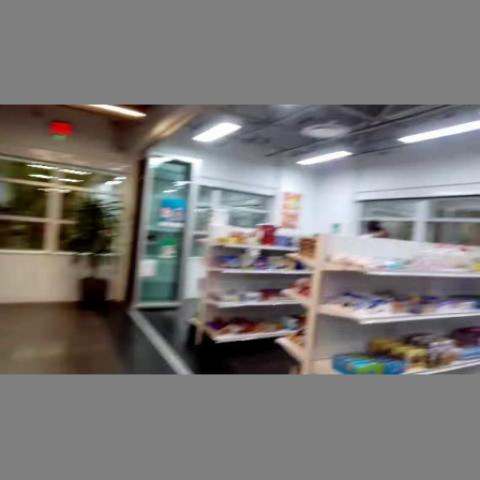

backbone
torch.Size([32768, 4]) torch.Size([4]) torch.Size([768, 4])
tensor([3832.1523, 2076.3540, 1669.0234, 1612.2734], device='cuda:0')


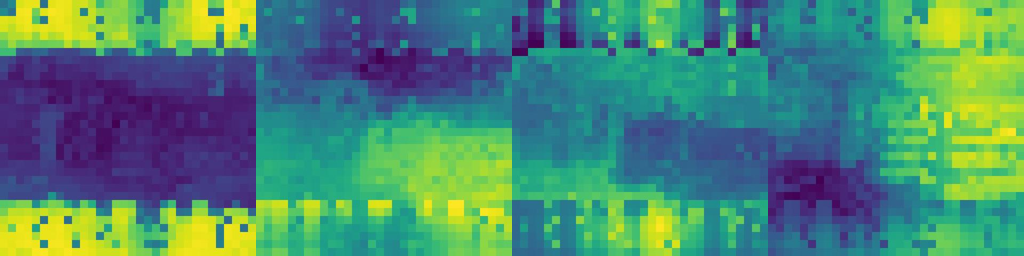

stx
torch.Size([32768, 4]) torch.Size([4]) torch.Size([768, 4])
tensor([642.5897, 477.4098, 375.4677, 333.5445], device='cuda:0')


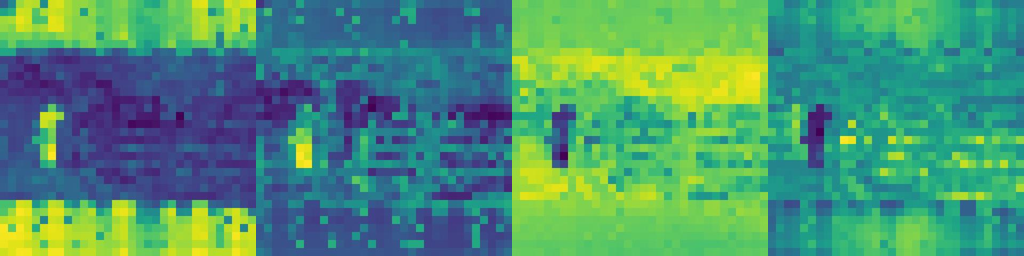

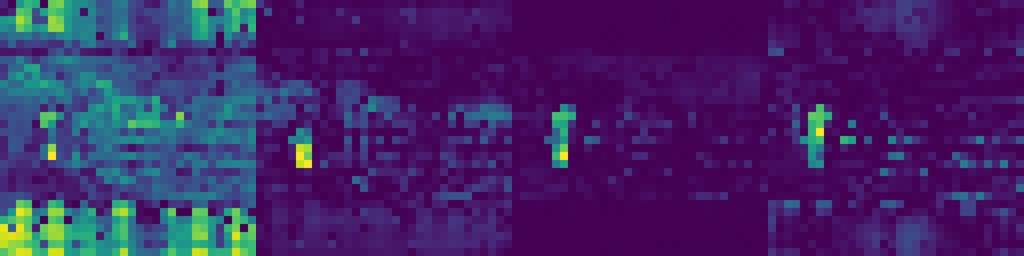

late_reduce
torch.Size([32768, 4]) torch.Size([4]) torch.Size([256, 4])
tensor([312.3148, 291.8520, 230.2144, 223.9048], device='cuda:0')


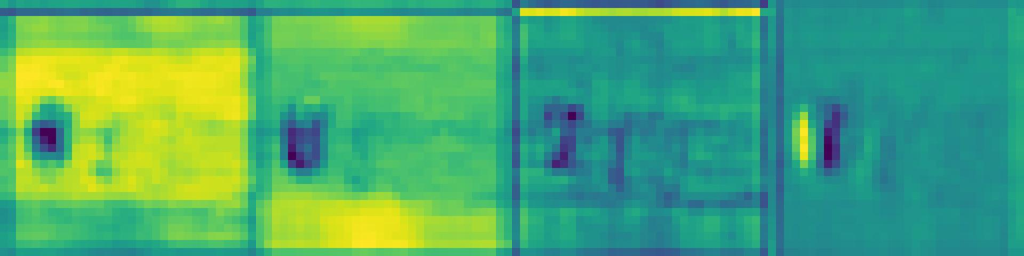

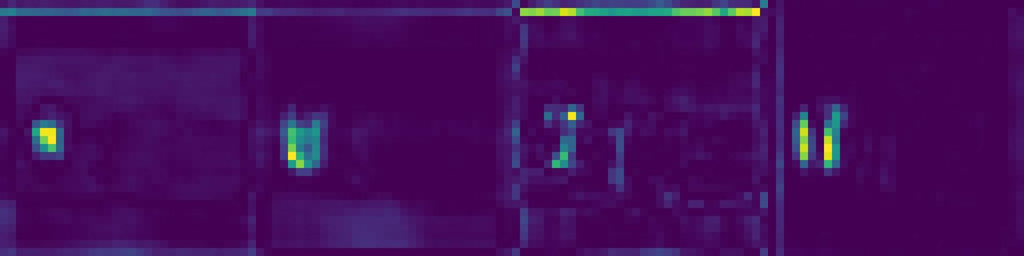

conv
torch.Size([32768, 4]) torch.Size([4]) torch.Size([256, 4])
tensor([915.1700, 799.4537, 541.5399, 447.8480], device='cuda:0')


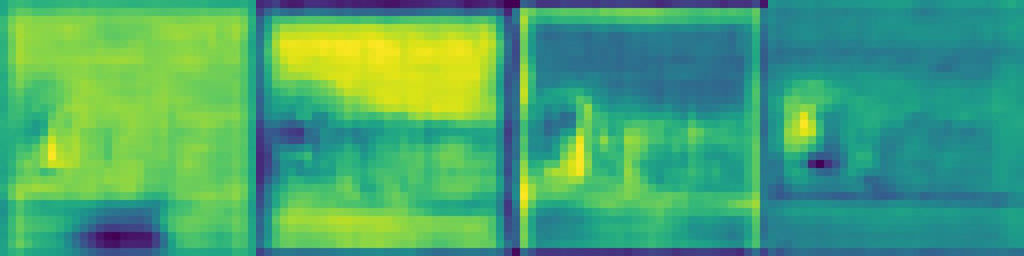

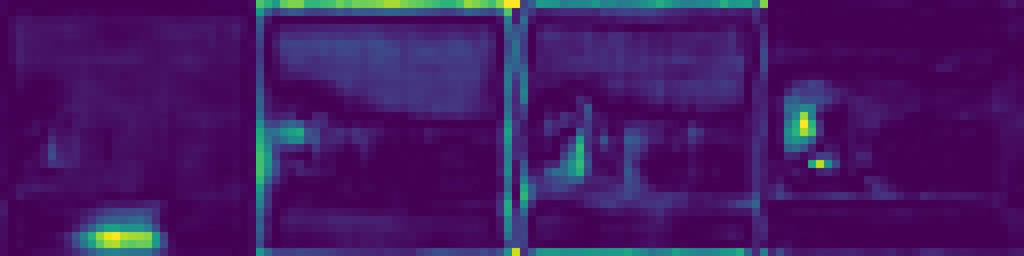

In [8]:
def feats2score(feats, q=4):
    torch.manual_seed(42)
    feat = rearrange(feats, 't c h w -> (t h w) c')
    U, S, V = torch.pca_lowrank(feat, q=q)
    print(U.shape, S.shape, V.shape)
    print(S)
    _feat = feat - feat.mean(dim=0)
    score_map = rearrange(_feat @ V, '(t h w) q -> t q h w', t=t, h=h, w=w)
    return score_map

def gauss(score_map):
    score_map = 1. - torch.exp(-1 * score_map ** 2 / 1000)
    return score_map

Q = 4
_, fidxs = torch.where(batch['gt_probs'] > 1e-3)
fidx = fidxs[1].item()
display(ten2pil(batch['segment'][0, fidx]))

print('backbone')
score_map = feats2score(output_dict['feat']['clip']['backbone'], q=Q)
images = [ten2pil(score_map[fidx, q]) for q in range(Q)]
display(make_image_grid(images, rows=1, cols=len(images), resize=256))

if reduce_key == 'reduce':
    print('reduce')
    score_map = feats2score(output_dict['feat']['clip'][reduce_key], q=Q)
    images = [ten2pil(score_map[fidx, q]) for q in range(Q)]
    display(make_image_grid(images, rows=1, cols=len(images), resize=256))

print('stx')
score_map = feats2score(output_dict['feat']['clip']['stx'], q=Q)
images = [ten2pil(score_map[fidx, q]) for q in range(Q)]
display(make_image_grid(images, rows=1, cols=len(images), resize=256))
score_map = gauss(score_map)
images = [ten2pil(score_map[fidx, q]) for q in range(Q)]
display(make_image_grid(images, rows=1, cols=len(images), resize=256))

if reduce_key == 'late_reduce':
    print('late_reduce')
    score_map = feats2score(output_dict['feat']['clip'][reduce_key], q=Q)
    images = [ten2pil(score_map[fidx, q]) for q in range(Q)]
    display(make_image_grid(images, rows=1, cols=len(images), resize=256))
    score_map = gauss(score_map)
    images = [ten2pil(score_map[fidx, q]) for q in range(Q)]
    display(make_image_grid(images, rows=1, cols=len(images), resize=256))

if 'conv' in output_dict['feat']['clip']:
    print('conv')
    score_map = feats2score(output_dict['feat']['clip']['conv'], q=Q)
    images = [ten2pil(score_map[fidx, q]) for q in range(Q)]
    display(make_image_grid(images, rows=1, cols=len(images), resize=256))
    score_map = gauss(score_map)
    images = [ten2pil(score_map[fidx, q]) for q in range(Q)]
    display(make_image_grid(images, rows=1, cols=len(images), resize=256))

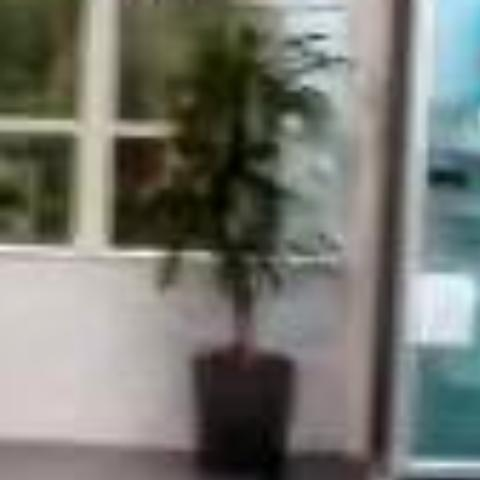

backbone
torch.Size([1024, 4]) torch.Size([4]) torch.Size([768, 4])
tensor([551.9475, 419.0273, 379.5589, 281.0879], device='cuda:0')


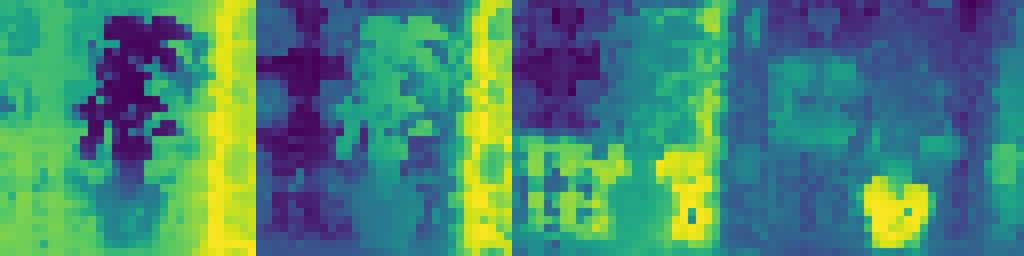

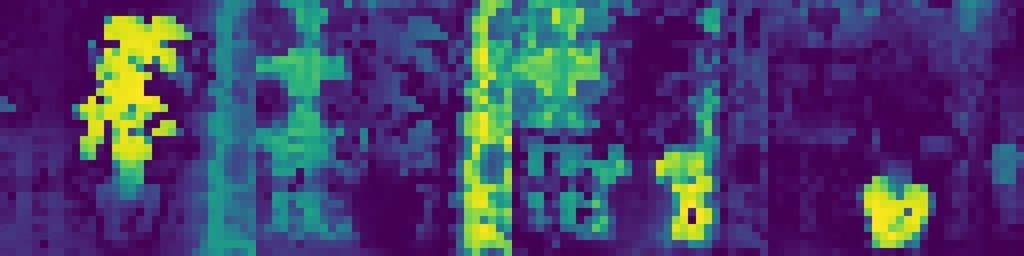

tensor([[[    0.0023,     0.0045,     0.0001,     0.0098,     0.0125,  ...,     0.2334,     0.3872,     0.3708,     0.3249,     0.2569],
         [    0.0011,     0.0042,     0.0031,     0.0170,     0.0050,  ...,     0.3031,     0.3700,     0.3541,     0.2520,     0.1287],
         [    0.0077,     0.0082,     0.0041,     0.0127,     0.0026,  ...,     0.3866,     0.3935,     0.2738,     0.1745,     0.1091],
         [    0.0023,     0.0089,     0.0100,     0.0139,     0.0120,  ...,     0.3877,     0.4031,     0.2486,     0.2118,     0.1042],
         [    0.0054,     0.0248,     0.0067,     0.0147,     0.0110,  ...,     0.3217,     0.3853,     0.1665,     0.2286,     0.0993],
         ...,
         [    0.0725,     0.0777,     0.1245,     0.1153,     0.1063,  ...,     0.4238,     0.2267,     0.2550,     0.2640,     0.3068],
         [    0.1114,     0.1208,     0.1142,     0.1140,     0.0445,  ...,     0.4214,     0.3411,     0.3285,     0.2290,     0.3095],
         [    0.1299,     0

late_reduce
torch.Size([784, 4]) torch.Size([4]) torch.Size([256, 4])
tensor([208.5753, 146.9096, 132.4391, 108.4530], device='cuda:0')


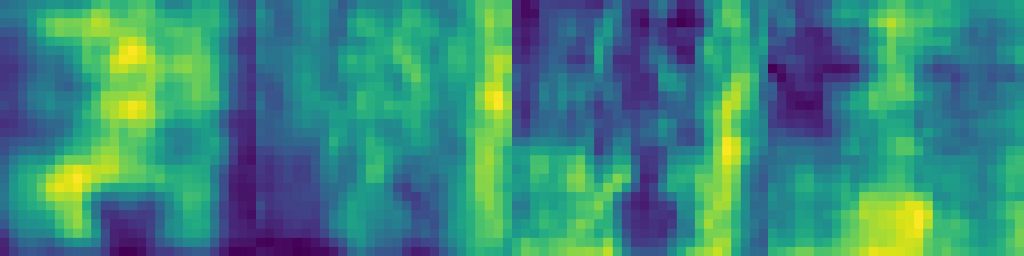

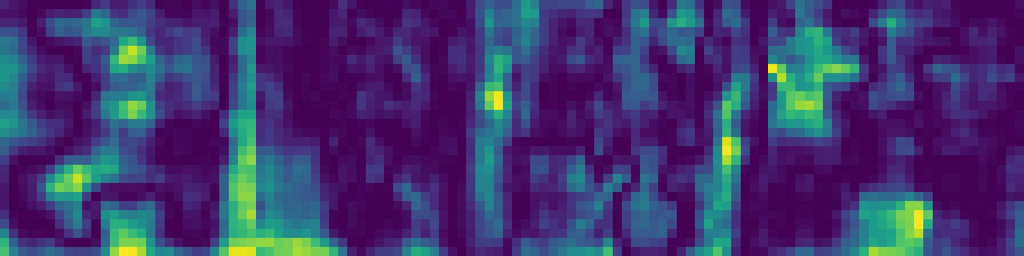

late_reduce from clip to query
torch.Size([25088, 4]) torch.Size([4]) torch.Size([256, 4])
tensor([264.7867, 207.7954, 173.9335, 154.9815], device='cuda:0')


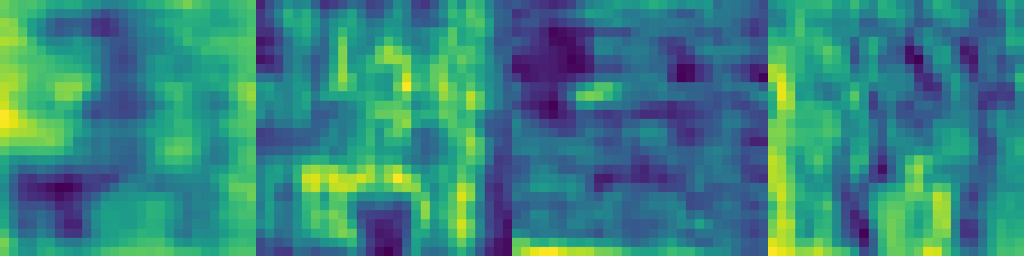

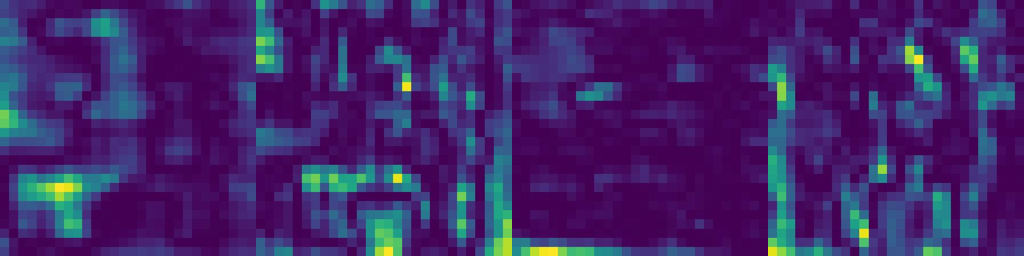

In [9]:
def feat2pcscore(feat_pca, feat_proj=None, q=4):
    *_, h, w = feat_pca.shape
    torch.manual_seed(42)
    if feat_pca.dim() == 4:
        feat_pca = rearrange(feat_pca, 't c h w -> (t h w) c')
    else:
        feat_pca = rearrange(feat_pca, 'c h w -> (h w) c')
    if feat_proj is None:
        feat_proj = feat_pca
    else:
        feat_proj = rearrange(feat_proj, 'c h w -> (h w) c')
    U, S, V = torch.pca_lowrank(feat_pca, q=q)
    print(U.shape, S.shape, V.shape)
    print(S)
    _feat = feat_proj - feat_proj.mean(dim=0)
    score_map = rearrange(_feat @ V, '(h w) q -> q h w', h=h, w=w)
    return score_map

def gauss(score_map, tau=1000):
    score_map = 1. - torch.exp(-1 * score_map ** 2 / tau)
    return score_map

display(ten2pil(batch['query'][0]))

Q = 4

print('backbone')
score_map = feat2pcscore(output_dict['feat']['query']['backbone'][0], q=Q)
images = [ten2pil(score_map[q]) for q in range(Q)]
display(make_image_grid(images, rows=1, cols=len(images), resize=256))
score_map = gauss(score_map)
images = [ten2pil(score_map[q]) for q in range(Q)]
display(make_image_grid(images, rows=1, cols=len(images), resize=256))
torch.set_printoptions(precision=4, sci_mode=False, threshold=5, edgeitems=5, linewidth=1000)

display(score_map)

print(reduce_key)
score_map = feat2pcscore(output_dict['feat']['query'][reduce_key][0][..., 2:-2, 2:-2], q=Q)
images = [ten2pil(score_map[q]) for q in range(Q)]
display(make_image_grid(images, rows=1, cols=len(images), resize=256))
score_map = gauss(score_map)
images = [ten2pil(score_map[q]) for q in range(Q)]
display(make_image_grid(images, rows=1, cols=len(images), resize=256))

print(reduce_key, 'from clip to query')
score_map = feat2pcscore(output_dict['feat']['clip'][reduce_key][..., 2:-2, 2:-2], output_dict['feat']['query'][reduce_key][0][..., 2:-2, 2:-2], q=Q)
images = [ten2pil(score_map[q]) for q in range(Q)]
display(make_image_grid(images, rows=1, cols=len(images), resize=256))
score_map = gauss(score_map)
images = [ten2pil(score_map[q]) for q in range(Q)]
display(make_image_grid(images, rows=1, cols=len(images), resize=256))

In [10]:
output_dict['info_dict']['preds_top']['prob'].sigmoid()

tensor([[0.2300, 0.3983, 0.5222, 0.1383, 0.1862,  ..., 0.1298, 0.1326, 0.1109, 0.0953, 0.0936]], device='cuda:0')

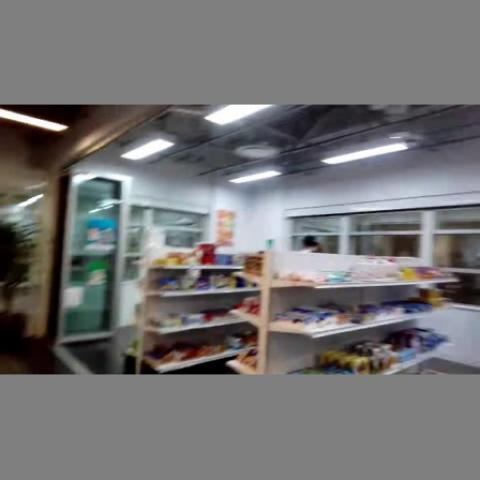

torch.Size([32768, 4]) torch.Size([4]) torch.Size([256, 4])
tensor([915.1700, 799.4537, 541.5399, 447.8480], device='cuda:0')


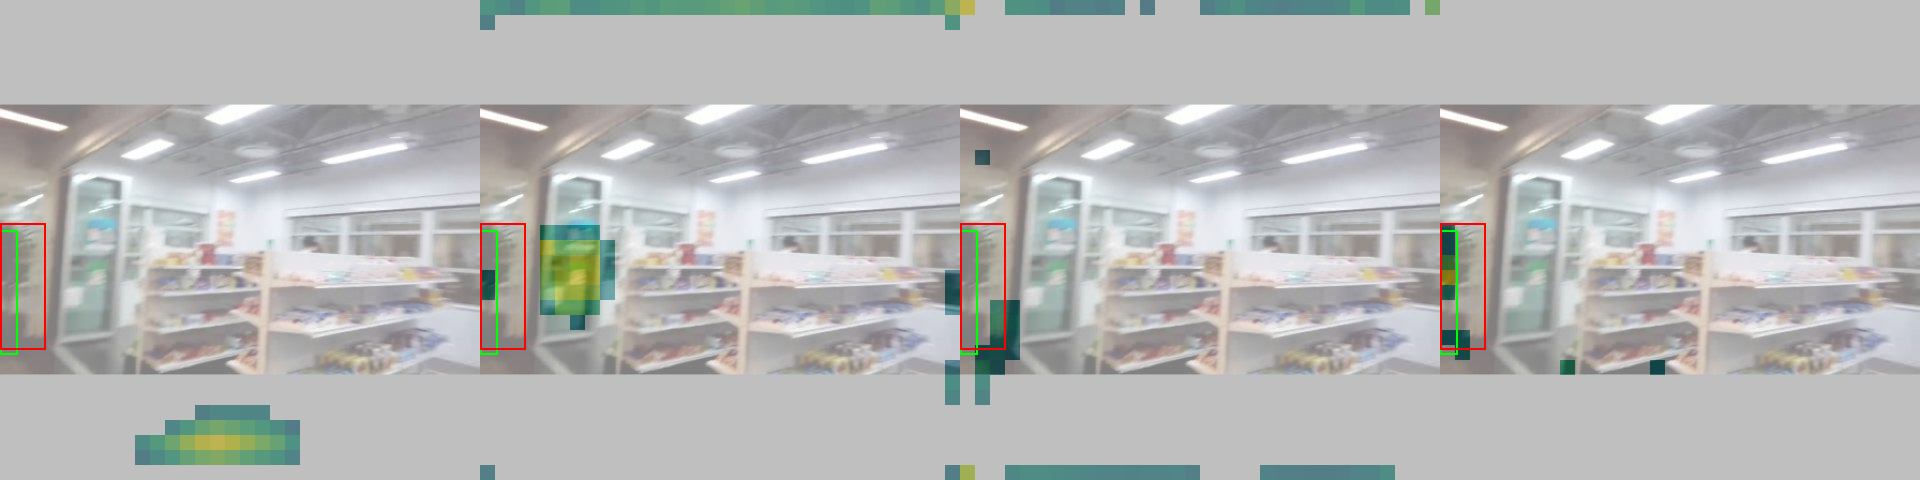

In [11]:
from PIL import ImageDraw

fidx = fidxs[2].item()
# qidx = 2

image1 = ten2pil(batch['segment'][0, fidx]).convert('RGBA')
display(image1)

gy1, gx1, gy2, gx2 = (batch['gt_bboxes'][0, fidx] * image1.size[0]).cpu().numpy().astype(int)
py1, px1, py2, px2 = (image1.size[0] * output_dict['info_dict']['preds_top']['bbox'][0, fidx]).cpu().numpy().astype(int)

score_map1 = feats2score(output_dict['feat']['clip'].get('conv', output_dict['feat']['clip'][reduce_key]), q=Q)
score_map2 = gauss(score_map1, tau=1000)

images = []
for qidx in range(4):
    s = score_map2[fidx, qidx]
    s -= s.min()
    s /= s.max()

    s_np = s.cpu().numpy()
    image2 = ten2pil(s, alpha=(s_np > 0.4).astype(np.uint8))

    image = Image.blend(image1, image2, alpha=0.5)
    image.putalpha(255)

    draw = ImageDraw.Draw(image)
    draw.rectangle([(gx1, gy1), (gx2, gy2)], outline=(0, 255, 0), width=2)
    draw.rectangle([(px1, py1), (px2, py2)], outline=(255, 0, 0), width=2)
    images.append(image)

make_image_grid(images, rows=1, cols=len(images))